In [1]:
import plotly.offline as py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
from prophet import Prophet
from fancyimpute import IterativeImputer
import seaborn as sns

In [2]:
data = pd.read_csv('final_data.csv', low_memory = False)
data.drop(data.columns[0], axis=1, inplace = True)

In [3]:
data['id'] = pd.DatetimeIndex(data['id'])
data['day_of_week'] = data['id'].dt.day_name()
data['id'] = data['id'].dt.strftime('%Y-%m-%d %H')
data.drop(['date'], axis = 1, inplace = True)
# data.drop(data.columns[0], axis = 1, inplace = True)



In [4]:
# SARIMA output taken as input for prophet model

sarima = pd.read_csv('sarima_predictions.csv')
sarima

,id,valeur_NO2_predict,valeur_CO_predict,valeur_O3_predict,valeur_PM10_predict,valeur_PM25_predict
0,2020-01-01 00,23.106545,0.169895,35.327932,NaN,11.054812
1,2020-01-01 01,23.106545,0.169895,35.327932,NaN,11.054812
2,2020-01-01 02,23.106545,0.169895,35.327932,NaN,11.054812
3,2020-01-01 03,23.106545,0.169895,35.327932,NaN,11.054812
4,2020-01-01 04,23.106545,0.169895,35.327932,NaN,11.054812
...,...,...,...,...,...,...
40986,2024-09-03 18,24.774978,0.218304,46.649043,NaN,11.785836
40987,2024-09-03 19,24.783153,0.218201,46.652896,NaN,11.802284
40988,2024-09-03 20,24.791328,0.218098,46.656748,NaN,11.818732
40989,2024-09-03 21,24.799503,0.217996,46.660600,NaN,11.835180


# Modelling

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40991 entries, 0 to 40990
Data columns (total 34 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  40991 non-null  object 
 1   valeur_NO2                          40991 non-null  float64
 2   valeur_CO                           40991 non-null  float64
 3   valeur_O3                           40991 non-null  float64
 4   valeur_PM10                         40991 non-null  float64
 5   valeur_PM25                         40991 non-null  float64
 6   temperature_2m (°C)                 40991 non-null  float64
 7   relative_humidity_2m (%)            40991 non-null  int64  
 8   dew_point_2m (°C)                   40991 non-null  float64
 9   apparent_temperature (°C)           40991 non-null  float64
 10  precipitation (mm)                  40991 non-null  float64
 11  rain (mm)                           40991

In [6]:
import pandas as pd

# Assuming df is your DataFrame containing all the data

# Selecting the target columns and potential regressor columns
target_columns = [
    'valeur_NO2', 
    'valeur_CO', 
    'valeur_O3', 
    'valeur_PM10', 
    'valeur_PM25'
]

# Include all the columns you want to check for correlation, except the ID and other non-numeric columns
potential_regressors = [
    'temperature_2m (°C)', 
    'relative_humidity_2m (%)', 
    'dew_point_2m (°C)', 
    'apparent_temperature (°C)', 
    'precipitation (mm)', 
    'rain (mm)', 
    'snowfall (cm)', 
    'snow_depth (m)', 
    'surface_pressure (hPa)', 
    'cloud_cover (%)', 
    'wind_speed_10m (km/h)', 
    'wind_speed_100m (km/h)', 
    'wind_direction_10m (°)', 
    'wind_direction_100m (°)', 
    'wind_gusts_10m (km/h)', 
    'soil_temperature_0_to_7cm (°C)', 
    'soil_temperature_7_to_28cm (°C)', 
    'soil_temperature_28_to_100cm (°C)', 
    'soil_temperature_100_to_255cm (°C)', 
    'soil_moisture_0_to_7cm (m³/m³)', 
    'soil_moisture_7_to_28cm (m³/m³)', 
    'soil_moisture_28_to_100cm (m³/m³)', 
    'soil_moisture_100_to_255cm (m³/m³)', 
    '2_wheeler_motor', 
    '4_wheeler_motor', 
    'bikes_scooters'
]

# Concatenate target columns with regressor columns
correlation_df = data[target_columns + potential_regressors].corr()

# Select only the correlations of target columns with regressors
target_corr = correlation_df.loc[target_columns, potential_regressors]

# Filter correlations above 0.5 or below -0.5
significant_corr = target_corr[(target_corr > 0.5) | (target_corr < -0.5)]

# Create a DataFrame to hold the correlation pairs
correlation_pairs = []

for target in target_columns:
    for regressor in potential_regressors:
        corr_value = significant_corr.loc[target, regressor]
        if not pd.isnull(corr_value):  # Only include non-null values
            correlation_pairs.append({'Target': target, 'Regressor': regressor, 'Correlation': corr_value})

# Convert to a DataFrame for better display
correlation_pairs_df = pd.DataFrame(correlation_pairs)

# Print the significant correlation pairs
print("Correlation Pairs with |Correlation| > 0.5:")
print(correlation_pairs_df)

Correlation Pairs with |Correlation| > 0.5:
      Target                       Regressor  Correlation
0  valeur_O3             temperature_2m (°C)     0.578206
1  valeur_O3        relative_humidity_2m (%)    -0.697546
2  valeur_O3       apparent_temperature (°C)     0.511857
3  valeur_O3  soil_temperature_0_to_7cm (°C)     0.563783


## NO2

In [7]:
data_NO2 = data[['id', 'valeur_NO2', 'temperature_2m (°C)', 'wind_speed_10m (km/h)', 'wind_gusts_10m (km/h)', 'soil_temperature_0_to_7cm (°C)',  'relative_humidity_2m (%)', 'apparent_temperature (°C)', 'soil_temperature_0_to_7cm (°C)']].rename(columns={'id' : 'ds', 'valeur_NO2' : 'y'})

data_NO2

,ds,y,temperature_2m (°C),wind_speed_10m (km/h),wind_gusts_10m (km/h),soil_temperature_0_to_7cm (°C),relative_humidity_2m (%),apparent_temperature (°C),soil_temperature_0_to_7cm (°C)
0,2020-01-01 00,42.900000,-0.2,2.5,5.8,1.1,99,-2.7,1.1
1,2020-01-01 01,33.600000,2.6,3.7,7.6,1.8,98,0.3,1.8
2,2020-01-01 02,29.300000,2.1,3.8,7.2,2.2,100,-0.3,2.2
3,2020-01-01 03,30.500000,1.9,4.9,8.6,2.4,100,-0.7,2.4
4,2020-01-01 04,29.300000,2.2,7.3,13.3,2.6,98,-0.7,2.6
...,...,...,...,...,...,...,...,...,...
40986,2024-09-03 18,22.476504,21.1,5.0,18.4,21.7,57,21.1,21.7
40987,2024-09-03 19,25.452015,19.7,5.1,9.0,21.1,64,19.8,21.1
40988,2024-09-03 20,24.303319,18.7,7.3,13.0,20.4,67,18.4,20.4
40989,2024-09-03 21,28.484285,16.9,6.8,12.2,19.6,76,16.7,19.6


In [8]:
# Select only 'id' and 'valeur_NO2' from sarima and rename 'valeur_NO2' to 'sarima_pred_NO2'
sarima_NO2 = sarima[['id', 'valeur_NO2_predict']].rename(columns={'valeur_NO2_predict ': 'sarima_pred_NO2'})

# Merge sarima_NO2 with data_NO2 on 'ds' and 'id' columns
data_NO2 = data_NO2.merge(sarima_NO2, left_on='ds', right_on='id', how='left')

# Drop the extra 'id' column after the merge if it's no longer needed
data_NO2 = data_NO2.drop(columns=['id'])
data_NO2['ds'] = pd.DatetimeIndex(data_NO2['ds'])

In [9]:
data_NO2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40991 entries, 0 to 40990
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   ds                              40991 non-null  datetime64[ns]
 1   y                               40991 non-null  float64       
 2   temperature_2m (°C)             40991 non-null  float64       
 3   wind_speed_10m (km/h)           40991 non-null  float64       
 4   wind_gusts_10m (km/h)           40991 non-null  float64       
 5   soil_temperature_0_to_7cm (°C)  40991 non-null  float64       
 6   relative_humidity_2m (%)        40991 non-null  int64         
 7   apparent_temperature (°C)       40991 non-null  float64       
 8   soil_temperature_0_to_7cm (°C)  40991 non-null  float64       
 9   valeur_NO2_predict              40991 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 3.4 MB


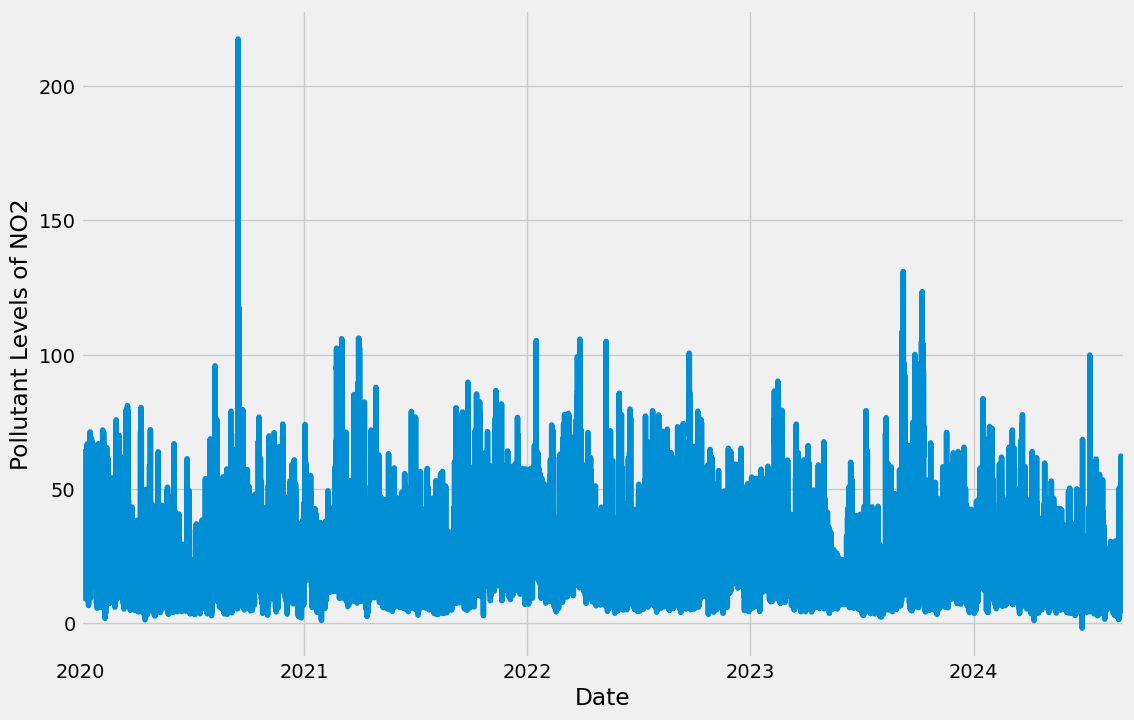

In [10]:
NO2 = data_NO2.set_index('ds')['y'].plot(figsize = (12, 8))
NO2.set_ylabel('Pollutant Levels of NO2')
NO2.set_xlabel('Date')

plt.show()

In [11]:
#define loss function 
def mae(y_true, y_pred):
    
    # Convert inputs to numpy arrays for easier calculations
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate the MAE
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

In [12]:
data_NO2_train.info()

NameError: name 'data_NO2_train' is not defined

In [ ]:
data_NO2_train, data_NO2_test= np.split(data_NO2, [int(.67 *len(data_NO2))])

model1 = Prophet()
model1.add_regressor('temperature_2m (°C)')
model1.add_regressor('wind_speed_10m (km/h)')
model1.add_regressor('wind_gusts_10m (km/h)')
model1.add_regressor('soil_temperature_0_to_7cm (°C)')
model1.add_regressor('relative_humidity_2m (%)')
model1.add_regressor('apparent_temperature (°C)')
model1.add_regressor('valeur_NO2_predict')
model1.fit(data_NO2_train)

In [ ]:
test_forecast_NO2 = model1.predict(data_NO2_test)
test_forecast_NO2 = test_forecast_NO2.rename(columns = {'ds' : 'id', 'yhat' : 'valeur_NO2'})
test_forecast_NO2_new = test_forecast_NO2[['id', 'valeur_NO2']].copy()

In [ ]:
test_forecast_NO2_new

In [ ]:
NO2_mae = mae(data_NO2_test['y'], test_forecast_NO2_new['valeur_NO2'])
NO2_mae

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'data_NO2_test' and 'test_forecast_NO2_new' are your DataFrames

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(data_NO2_test['y'], label="Actual NO2 Levels", color="blue", linestyle="-", marker="o")
plt.plot(test_forecast_NO2_new['valeur_NO2'], label="Predicted NO2 Levels", color="red", linestyle="--", marker="x")

# Set labels and title
plt.xlabel("Time")
plt.ylabel("NO2 Levels")
plt.title("Actual vs Predicted NO2 Levels")
plt.legend()

# Show the plot
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
forecast_NO2 = model.predict(test)
forecast_NO2 = forecast_NO2.rename(columns = {'ds' : 'id', 'yhat' : 'valeur_NO2'})
predictions_NO2 = forecast_NO2[['id', 'valeur_NO2']].copy()
predictions_NO2